In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
c = 2.99792458e8 # m s^-1
h = 6.62607015e-34 # J s
k_B = 1.380649e-23 # J K^-1
pi = np.pi
ep0 = 8.8542e-12   # [Fm^-1]=[C^2 N^-1 m^-2] dielectric const in vaccum

In [ ]:
def SWG_frac2index(freq, n1, n2, f, pitch):
    '''
    physical dimension of pitch
    width of n2 (nominally take as a material)cal
    (freq, n1, n2, f, pitch) = (freq_sws, n_vac, n_alumina, area_frac, pitch)
    '''
    r = pitch/c*freq
    ep1 = n1**2.*ep0
    ep2 = n2**2.*ep0

    ep01 = (1.-f)*ep1+f*ep2
    ep02 = 1./((1.-f)/ep1+f/ep2)

    ep21 = ep01*(1.+pi**2/3.*r**2.*f**2*(1.-f)**2*(ep2-ep1)**2./(ep0*ep01))
    ep22 = ep02*(1.+pi**2/3.*r**2.*f**2*(1.-f)**2*(ep2-ep1)**2.*ep01/ep0*(ep02/ep2/ep1)**2.)

    ep_that = (1.-f)*ep1+f*ep22
    ep_lhat = 1./((1.-f)/ep1+f/ep21)

    n_ave = (1.-f**2.)*n1+f**2*n2
    n_that=np.sqrt(ep_that/ep0)
    n_lhat=np.sqrt(ep_lhat/ep0)

    n = .2*(n_ave+2.*n_that+2.*n_lhat)
    w = f*pitch

    return n, w


def oblique_basic_multilayer_r_t_incloss( n, losstan, d, freq_i, freq_f, freq_int, angle_i, incpol):

    num=len(d) #; the number of layer not including two ends
    const = np.sqrt((8.85e-12)/(4.*pi*1e-7)) #SI unit sqrt(dielectric const/permiability)

    # ;-----------------------------------------------------------------------------------
    # ; angle of refraction
    angle = np.zeros(num+2)          # ; angle[0]=incident angle
    angle[0] = angle_i
    for i in range(0,num+1): angle[i+1] = np.arcsin(np.sin(angle[i])*n[i]/n[i+1])

    # ;-----------------------------------------------------------------------------------
    # ; define the frequency span
    l = int((freq_f - freq_i)/freq_int + 1.)
    output = np.zeros((3,l),'complex') # output = dcomplexarr(3,l)

    # ;-----------------------------------------------------------------------------------
    # ; define the effective thickness of each layer
    h = np.zeros(num,'complex')
    n_comparr = np.zeros(len(n),'complex')
    n_comparr[0] = complex(n[0], -0.5*n[0]*losstan[0])
    n_comparr[num+1] = complex(n[num+1], -0.5*n[num+1]*losstan[num+1])

    # ;-----------------------------------------------------------------------------------
    # ; for loop for various thickness of air gap between each layer
    for j in range(0,l):
        for i in range(0,num):
            n_comparr[i+1] = complex(n[i+1], -0.5*n[i+1]*losstan[i+1])
            h[i] = n_comparr[i+1]*d[i]*np.cos(angle[i+1]) # ;effective thickness of 1st layer

        freq = freq_int * j + freq_i
        k = 2.*pi*freq/c

        # ;===========================================
        # ; Y: Y[0]=vacuum, Y[1]=1st layer..., Y[num+1]=end side
        Y = np.zeros(num+2,'complex')
        for i in range(0,num+2):
            if (incpol == 1):
                Y[i] = const*n_comparr[i]*np.cos(angle[i])
                cc = 1.
            if (incpol == -1):
                Y[i] = const*n_comparr[i]/np.cos(angle[i])
                cc = np.cos(angle[num+1])/np.cos(angle[0])

        # ;===========================================
        # ; define matrix for single layer
        m = np.identity((2),'complex')    # ; net matrix
        me = np.zeros((2,2),'complex') # ; me[0]=1st layer, ...
        for i in range(0,num):
            me[0,0] = complex(np.cos(k*h[i]), 0.)
            me[1,0] = complex(0., np.sin(k*h[i])/Y[i+1])
            me[0,1] = complex(0., np.sin(k*h[i])*Y[i+1])
            me[1,1] = complex(np.cos(k*h[i]), 0.)
            m = np.dot(m,me)

        r = (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]-m[0,1]*cc-Y[num+1]*m[1,1]) / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])
        t = 2.*Y[0] / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])

        output[0,j] = freq+0.j #; unit of [Hz]
        output[1,j] = r
        output[2,j] = t

    return output

def Plot_cross_section(width_arr,klop_d,p):
        width_for_plot = np.concatenate((-width_arr[::-1]/2-p,width_arr/2-p,-width_arr[::-1]/2,width_arr/2,-width_arr[::-1]/2+p,width_arr/2+p))*1e+3
        depth_for_plot = np.concatenate((klop_d[::-1],klop_d,klop_d[::-1],klop_d,klop_d[::-1],klop_d))*1e+3

        fig = plt.figure(figsize = (6,4))
        ax = fig.add_subplot(111)

        ax.plot(width_for_plot, depth_for_plot,'b-', label = 'Design')


        ax.set_ylim(np.max(depth_for_plot) + np.max(depth_for_plot)*0.05,-0.05)
        ax.set_xlabel('Length [mm]',fontsize = 20)
        ax.set_ylabel('Depth [mm]',fontsize = 20)
        ax.tick_params(labelsize=16)
        ax.grid()
        fig.tight_layout()
        plt.show()
        plt.close()

In [ ]:
### Variable
n_0 = 1.
n_s = 3.12
losstan_s = 1.e-4
d_s = 3.e-3
angle_i = 0.
incpol = 1
freq_i = 140e9
freq_f = 220e9
freq_int = 1.e9

In [ ]:
angle_i = angle_i/180.*pi #radian
freq_c = (freq_f+freq_i)/2

wavelength_i = c/freq_i
wavelength_f = c/freq_f
wavelength_c = c/freq_c

n_AR = np.sqrt(n_0*n_s)
d_AR = wavelength_i/(4*n_AR)

pitch = wavelength_f/(n_s+np.sin(np.deg2rad(angle_i)))

In [ ]:
### sample with AR layer
n_arr = np.hstack((np.array(1.), np.array([n_AR,n_s,n_AR]), np.array([1.])))
losstan_arr = np.hstack((np.zeros(1), np.array([losstan_s, losstan_s,losstan_s]), np.zeros(1)))
d_arr = np.hstack((np.array([d_AR,d_s,d_AR])))

print("d_AR = {} [mm]".format(d_AR*10**3))
print("n_AR = {}".format(n_AR))
print("n_arr = {}".format(n_arr))
print("losstan_arr = {}".format(losstan_arr))
print("d_arr = {} [mm]".format(d_arr*10**3))


d_AR = 0.3030786742885342 [mm]
n_AR = 1.7663521732655694
n_arr = [1.         1.76635217 3.12       1.76635217 1.        ]
losstan_arr = [0.     0.0001 0.0001 0.0001 0.    ]
d_arr = [0.30307867 3.         0.30307867] [mm]


In [ ]:
### sample with structure AR
num_ar = 10
top_frac = 0.6
bottom_frac = 1.0

d_ar_layer = d_AR/float(num_ar)

area_frac_top = np.linspace(top_frac, bottom_frac, num_ar)
area_frac_bottom = area_frac_top[::-1]

n_ar_top, w_top = SWG_frac2index(freq_i, n_0, n_s, area_frac_top, pitch)
n_ar_bottom, w_bottom = SWG_frac2index(freq_i, n_0, n_s, area_frac_bottom, pitch)

n_arr = np.hstack((np.array(n_0), n_ar_top, np.array([n_s]), n_ar_bottom, np.array([n_0])))
losstan_arr = np.hstack((
np.zeros(1), np.array([losstan_s]*num_ar), np.array([losstan_s]), np.array([losstan_s]*num_ar), np.zeros(1)))

d_top_arr = np.ones(num_ar) * d_ar_layer
d_bottom_arr = np.ones(num_ar) * d_ar_layer
d_arr = np.hstack((d_top_arr, d_s, d_bottom_arr))

print("n_arr = {}".format(n_arr))
print("losstan_arr = {}".format(losstan_arr))
print("d_arr = {} [mm]".format(d_arr*10**3))


n_arr = [1.         1.48273841 1.57052346 1.67060677 1.78495126 1.91609861
 2.06748004 2.2440538  2.45411245 2.71723886 3.12       3.12
 3.12       2.71723886 2.45411245 2.2440538  2.06748004 1.91609861
 1.78495126 1.67060677 1.57052346 1.48273841 1.        ]
losstan_arr = [0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.    ]
d_arr = [0.03030787 0.03030787 0.03030787 0.03030787 0.03030787 0.03030787
 0.03030787 0.03030787 0.03030787 0.03030787 3.         0.03030787
 0.03030787 0.03030787 0.03030787 0.03030787 0.03030787 0.03030787
 0.03030787 0.03030787 0.03030787] [mm]


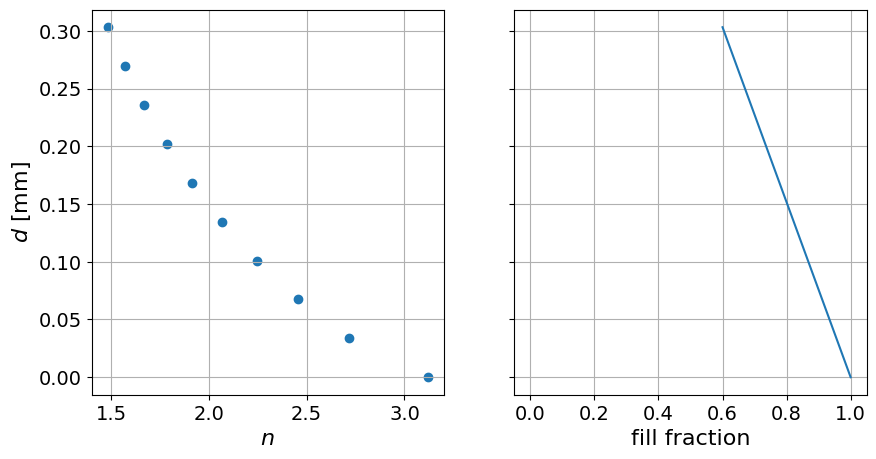

In [ ]:
d_AR_arr = np.linspace(0,d_AR,num_ar)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.scatter(n_ar_top,-d_AR_arr*10**3+np.max(d_AR_arr*10**3))
ax0.set_xlabel(r'$n$',fontsize=16)
ax0.set_ylabel(r'$d$ [mm]',fontsize=16)
ax0.tick_params(labelsize=14)
ax0.grid()

ax1.plot(area_frac_top,-d_AR_arr*10**3+np.max(d_AR_arr*10**3))
ax1.set_xlabel('fill fraction',fontsize=16)
ax1.tick_params(labelsize=14)
ax1.set_yticklabels([])
ax1.set_xlim(-0.05,1.05)
ax1.grid()
plt.show()

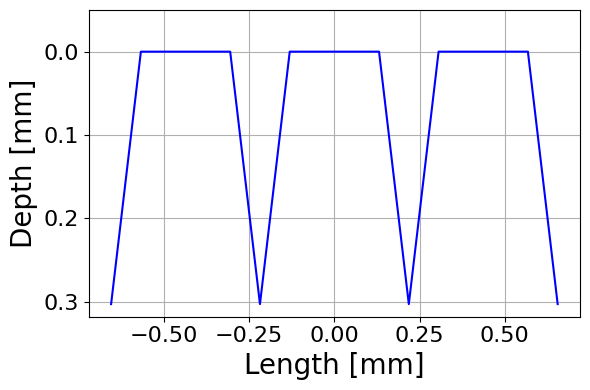

In [ ]:
Plot_cross_section(area_frac_top*pitch,d_AR_arr,pitch)

In [ ]:
freq_i_plot = 30e9
freq_f_plot = 600e9

out = oblique_basic_multilayer_r_t_incloss(n_arr, losstan_arr, d_arr, freq_i_plot, freq_f_plot, freq_int, angle_i, incpol)
freq_arr_GHz = out[0]*1.e-9
Reflectance = np.abs(out[1])**2
Transmittance = np.abs(out[2])**2

/usr/local/Cellar/python-matplotlib/3.9.0/libexec/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/Cellar/python-matplotlib/3.9.0/libexec/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


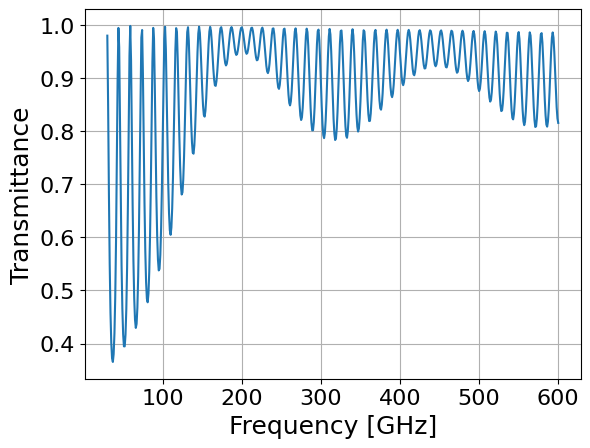

In [ ]:
fig,ax = plt.subplots()
ax.plot(freq_arr_GHz,Transmittance)
ax.grid()
ax.set_xlabel("Frequency [GHz]", fontsize=18)
ax.set_ylabel("Transmittance", fontsize=18)
ax.tick_params(labelsize=16)
#ax.set_xlim(140,220)
plt.show()